<a href="https://colab.research.google.com/github/IsaacFigNewton/DisCoFuzz/blob/main/DisCoFuzz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Config

## Import

In [10]:
from typing import Callable, Dict, List, Tuple, Set
import math
import numpy as np
import random
import nltk

nltk.download('wordnet')
nltk.download('framenet-17')
from nltk.corpus import wordnet as wn
from nltk.corpus import framenet as fn

import spacy

import pandas as pd

import scipy.stats as stats
from scipy.special import expit

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

import tensorflow as tf

from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading framenet-17: Package 'framenet-17' not found
[nltk_data]     in index


## Config

In [2]:
all_synsets = list(wn.all_synsets())
wn_dict = {
    'synset': list(),
    'lemmas': list(),
    'antonyms': list(),
    'gloss': list()
}

for s in all_synsets:
  lemmas = s.lemmas()
  antonyms = list()
  for lemma in lemmas:
    antonyms += list(lemma.antonyms())
  if len(lemmas) > 1 and len(antonyms) > 0:
    wn_dict['synset'].append(s.name())
    wn_dict['lemmas'].append([l.name() for l in lemmas])
    wn_dict['antonyms'].append([a.name() for a in antonyms])
    wn_dict['gloss'].append(s.definition())

wn_df = pd.DataFrame.from_dict(wn_dict)
wn_df.head()

,synset,lemmas,antonyms,gloss
0,abaxial.a.01,"[abaxial, dorsal]",[adaxial],facing away from the axis of an organ or organism
1,adaxial.a.01,"[adaxial, ventral]",[abaxial],nearest to or facing toward the axis of an org...
2,abducent.a.01,"[abducent, abducting]",[adducent],especially of muscles; drawing away from the m...
3,adducent.a.01,"[adducent, adductive, adducting]",[abducent],especially of muscles; bringing together or dr...
4,relative.a.01,"[relative, comparative]",[absolute],estimated by comparison; not absolute or complete


In [3]:
wn_df = wn_df.sample(frac=0.1).reset_index(drop=True)
print(f'Number of synsets: {len(wn_df)}')

Number of synsets: 267


In [4]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

# Classes

## FourierFuzzifier

In [6]:
import tensorflow as tf
import numpy as np
from typing import List

class FourierFuzzifier:
    """TensorFlow-accelerated version of FourierFuzzifier with set operations"""

    def __init__(self, sigma: float, kernel_size: int):
        self.kernel_size = kernel_size
        self.sigma = tf.constant(sigma, dtype=tf.float32)
        self.normalization = tf.constant(1.0 / (sigma * np.sqrt(2 * np.pi)), dtype=tf.float32)

        # Pre-compute Fourier coefficients for all k values
        k_values = tf.range(0, kernel_size + 1, dtype=tf.float32)
        self.fourier_coeffs = tf.exp(-0.5 * (self.sigma ** 2) * (k_values ** 2))
        self.fourier_coeffs = tf.tensor_scatter_nd_update(
            self.fourier_coeffs, [[0]], [1.0]  # DC component = 1
        )

    def _get_gaussian_at_mu_batch(self, mu: tf.Tensor) -> tf.Tensor:
        """
        Batch computation of Fourier series for Gaussians centered at multiple mu values.
        mu: shape (batch_size,)
        Returns: shape (batch_size, 2, kernel_size+1)
        """
        batch_size = tf.shape(mu)[0]
        k_range = tf.range(0, self.kernel_size + 1, dtype=tf.float32)

        # Broadcast for batch computation: (batch_size, kernel_size+1)
        k_mu = tf.expand_dims(k_range, 0) * tf.expand_dims(mu, 1)

        # Get coefficients for all k and mu
        coeffs = tf.expand_dims(self.fourier_coeffs, 0)  # (1, kernel_size+1)
        coeffs = tf.tile(coeffs, [batch_size, 1])  # (batch_size, kernel_size+1)

        # Compute cos and sin components
        cos_components = coeffs * tf.cos(k_mu)
        sin_components = coeffs * tf.sin(k_mu)

        # Set DC sin component to 0
        sin_components = tf.concat([
            tf.zeros([batch_size, 1], dtype=tf.float32),
            sin_components[:, 1:]
        ], axis=1)

        # Stack into (batch_size, 2, kernel_size+1)
        return tf.stack([cos_components, sin_components], axis=1)

    def evaluate_component_pdf(self, fuzzy_component: tf.Tensor, x: float) -> tf.Tensor:
        """
        Evaluate the probability density function at position x for a single component.

        fuzzy_component: shape (2, kernel_size+1)
        x: scalar float value
        Returns: scalar tf.Tensor
        """
        # Expand dimensions to create a batch of size 1
        fuzzy_component_batch = tf.expand_dims(fuzzy_component, axis=0)
        x_tensor = tf.constant(x, dtype=tf.float32)

        # Call batch version
        result_batch = self.evaluate_component_pdf_batch(fuzzy_component_batch, x_tensor)

        # Extract scalar result
        return tf.squeeze(result_batch)

    def evaluate_component_pdf_batch(self, fuzzy_components: tf.Tensor, x: tf.Tensor) -> tf.Tensor:
        """
        Batch evaluation of PDFs.
        fuzzy_components: shape (batch_size, 2, kernel_size+1)
        x: shape (batch_size,) or scalar
        Returns: shape (batch_size,)
        """
        if tf.rank(x) == 0:  # scalar
            x = tf.fill([tf.shape(fuzzy_components)[0]], x)

        # Compute harmonics for all k
        k_range = tf.range(0, self.kernel_size + 1, dtype=tf.float32)
        k_x = tf.expand_dims(k_range, 0) * tf.expand_dims(x, 1)  # (batch_size, kernel_size+1)

        cos_kx = tf.cos(k_x)
        sin_kx = tf.sin(k_x)

        # Compute result using batch matrix multiplication
        cos_contrib = tf.reduce_sum(fuzzy_components[:, 0, :] * cos_kx, axis=1)
        sin_contrib = tf.reduce_sum(fuzzy_components[:, 1, :] * sin_kx, axis=1)

        return self.normalization * (cos_contrib + sin_contrib)

    def evaluate_component_pdf_at_points(self, fuzzy_component: tf.Tensor, x_points: tf.Tensor) -> tf.Tensor:
        """
        Evaluate a single fuzzy component at multiple x positions.

        fuzzy_component: shape (2, kernel_size+1)
        x_points: shape (n_points,)
        Returns: shape (n_points,)
        """
        n_points = tf.shape(x_points)[0]

        # Replicate the component for each evaluation point
        fuzzy_component_batch = tf.tile(
            tf.expand_dims(fuzzy_component, axis=0),
            [n_points, 1, 1]
        )

        return self.evaluate_component_pdf_batch(fuzzy_component_batch, x_points)

    def _integrate_batch(self, a: tf.Tensor, lower: float = 0, upper: float = 1) -> tf.Tensor:
        """
        Batch integration.
        a: shape (batch_size, 2, kernel_size+1)
        Returns: shape (batch_size,)
        """
        batch_size = tf.shape(a)[0]

        # DC component
        integral = a[:, 0, 0] * (upper - lower)

        # Harmonic components - vectorized
        k_range = tf.range(1, self.kernel_size + 1, dtype=tf.float32)

        # Compute sin and cos terms for all k
        sin_upper = tf.sin(k_range * upper)
        sin_lower = tf.sin(k_range * lower)
        cos_upper = tf.cos(k_range * upper)
        cos_lower = tf.cos(k_range * lower)

        # Batch computation of contributions
        cos_contrib = tf.reduce_sum(
            a[:, 0, 1:] * (sin_upper - sin_lower) / k_range, axis=1
        )
        sin_contrib = tf.reduce_sum(
            -a[:, 1, 1:] * (cos_upper - cos_lower) / k_range, axis=1
        )

        integral = integral + cos_contrib + sin_contrib
        return integral / self.normalization

    def _integrate(self, a: tf.Tensor, lower: float = 0, upper: float = 1) -> tf.Tensor:
        """
        Single integration helper.
        a: shape (2, kernel_size+1)
        Returns: scalar
        """
        a_batch = tf.expand_dims(a, axis=0)
        result_batch = self._integrate_batch(a_batch, lower, upper)
        return tf.squeeze(result_batch)

    def _normalize_batch(self, a: tf.Tensor) -> tf.Tensor:
        """
        Batch normalization.
        a: shape (batch_size, 2, kernel_size+1)
        """
        total_integral = self._integrate_batch(a, 0, 1)  # (batch_size,)
        total_integral = tf.expand_dims(tf.expand_dims(total_integral, 1), 2)  # (batch_size, 1, 1)

        # Avoid division by zero
        total_integral = tf.where(
            tf.abs(total_integral) > 1e-10,
            total_integral,
            tf.ones_like(total_integral)
        )

        return a / total_integral

    def _normalize(self, a: tf.Tensor) -> tf.Tensor:
        """
        Single normalization helper.
        a: shape (2, kernel_size+1)
        Returns: shape (2, kernel_size+1)
        """
        a_batch = tf.expand_dims(a, axis=0)
        result_batch = self._normalize_batch(a_batch)
        return tf.squeeze(result_batch, axis=0)

    def _convolve_batch(self, a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
        """
        Batch convolution using FFT.
        a, b: shape (batch_size, 2, kernel_size+1)
        Returns: shape (batch_size, 2, kernel_size+1)
        """
        # Convert to complex representation
        A = tf.complex(a[:, 0, :], -a[:, 1, :])  # (batch_size, kernel_size+1)
        B = tf.complex(b[:, 0, :], -b[:, 1, :])

        # Batch FFT convolution
        A_fft = tf.signal.fft(tf.cast(A, tf.complex64))
        B_fft = tf.signal.fft(tf.cast(B, tf.complex64))
        C_fft = A_fft * B_fft
        C = tf.signal.ifft(C_fft)

        # Convert back to real - FIXED: Use tf.math.real and tf.math.imag
        C = tf.cast(C, tf.complex64)
        c_cos = tf.math.real(C)
        c_sin = -tf.math.imag(C)

        return tf.stack([c_cos, c_sin], axis=1)

    def _convolve(self, a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
        """
        Single convolution helper.
        a, b: shape (2, kernel_size+1)
        Returns: shape (2, kernel_size+1)
        """
        a_batch = tf.expand_dims(a, axis=0)
        b_batch = tf.expand_dims(b, axis=0)
        result_batch = self._convolve_batch(a_batch, b_batch)
        return tf.squeeze(result_batch, axis=0)

    def _differentiate_batch(self, a: tf.Tensor) -> tf.Tensor:
        """
        Batch differentiation.
        a: shape (batch_size, 2, kernel_size+1)
        Returns: shape (batch_size, 2, kernel_size+1)
        """
        batch_size = tf.shape(a)[0]

        # Initialize derivative arrays
        derivative_cos = tf.zeros([batch_size, self.kernel_size + 1], dtype=tf.float32)
        derivative_sin = tf.zeros([batch_size, self.kernel_size + 1], dtype=tf.float32)

        # DC component derivative is 0 (already zeros)

        # Harmonic components
        k_range = tf.range(1, self.kernel_size + 1, dtype=tf.float32)

        # d/dx[cos(kx)] = -k*sin(kx), d/dx[sin(kx)] = k*cos(kx)
        derivative_cos_k = k_range * a[:, 1, 1:]  # from sin terms
        derivative_sin_k = -k_range * a[:, 0, 1:]  # from cos terms

        # Concatenate DC (zero) with harmonic components
        derivative_cos = tf.concat([
            tf.zeros([batch_size, 1], dtype=tf.float32),
            derivative_cos_k
        ], axis=1)

        derivative_sin = tf.concat([
            tf.zeros([batch_size, 1], dtype=tf.float32),
            derivative_sin_k
        ], axis=1)

        return tf.stack([derivative_cos, derivative_sin], axis=1)

    def _differentiate(self, a: tf.Tensor) -> tf.Tensor:
        """
        Single differentiation helper.
        a: shape (2, kernel_size+1)
        Returns: shape (2, kernel_size+1)
        """
        a_batch = tf.expand_dims(a, axis=0)
        result_batch = self._differentiate_batch(a_batch)
        return tf.squeeze(result_batch, axis=0)

    # SET OPERATIONS

    def fuzzify(self, component: float) -> tf.Tensor:
        """
        Convert a real-valued component to a Fourier series representation of a Gaussian.
        component: scalar float
        Returns: shape (2, kernel_size+1)
        """
        mu = tf.constant([component], dtype=tf.float32)
        gaussian = self._get_gaussian_at_mu_batch(mu)
        normalized = self._normalize_batch(gaussian)
        return tf.squeeze(normalized, axis=0)

    def fuzzify_batch(self, components: tf.Tensor) -> tf.Tensor:
        """
        Batch fuzzification.
        components: shape (batch_size,)
        Returns: shape (batch_size, 2, kernel_size+1)
        """
        gaussians = self._get_gaussian_at_mu_batch(components)
        return self._normalize_batch(gaussians)

    def negation(self, a: tf.Tensor) -> tf.Tensor:
        """
        Fuzzy negation: NOT(a) = 1 - a
        a: shape (2, kernel_size+1)
        Returns: shape (2, kernel_size+1)
        """
        # Create representation of constant function 1
        one = tf.zeros_like(a)
        one = tf.tensor_scatter_nd_update(
            one, [[0, 0]], [1.0 / self.normalization.numpy()]
        )

        return self._normalize(one - a)

    def negation_batch(self, a: tf.Tensor) -> tf.Tensor:
        """
        Batch fuzzy negation: NOT(a) = 1 - a
        a: shape (batch_size, 2, kernel_size+1)
        Returns: shape (batch_size, 2, kernel_size+1)
        """
        batch_size = tf.shape(a)[0]

        # Create batch of constant function 1
        ones = tf.zeros_like(a)
        indices = tf.stack([
            tf.range(batch_size),
            tf.zeros(batch_size, dtype=tf.int32),
            tf.zeros(batch_size, dtype=tf.int32)
        ], axis=1)
        updates = tf.fill([batch_size], 1.0 / self.normalization.numpy())
        ones = tf.tensor_scatter_nd_update(ones, indices, updates)

        return self._normalize_batch(ones - a)

    def intersection(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Fuzzy intersection using product (min approximation).
        a, b: shape (2, kernel_size+1)
        Returns: shape (2, kernel_size+1)
        """
        result = self._convolve(a, b)
        if normalize:
            result = self._normalize(result)
        return result

    def intersection_batch(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Batch fuzzy intersection using product.
        a, b: shape (batch_size, 2, kernel_size+1)
        Returns: shape (batch_size, 2, kernel_size+1)
        """
        result = self._convolve_batch(a, b)
        if normalize:
            result = self._normalize_batch(result)
        return result

    def union(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Fuzzy union: a + b - a*b
        a, b: shape (2, kernel_size+1)
        Returns: shape (2, kernel_size+1)
        """
        convolved = self._convolve(a, b)
        result = a + b - convolved
        if normalize:
            result = self._normalize(result)
        return result

    def union_batch(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Batch fuzzy union: a + b - a*b
        a, b: shape (batch_size, 2, kernel_size+1)
        Returns: shape (batch_size, 2, kernel_size+1)
        """
        convolved = self._convolve_batch(a, b)
        result = a + b - convolved
        if normalize:
            result = self._normalize_batch(result)
        return result

    def similarity(self, a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
        """
        Compute similarity as cosine similarity in frequency domain.
        a, b: shape (2, kernel_size+1)
        Returns: scalar similarity
        """
        a_flat = tf.reshape(a, [-1])
        b_flat = tf.reshape(b, [-1])

        numerator = tf.reduce_sum(a_flat * b_flat)
        denominator_a = tf.sqrt(tf.reduce_sum(a_flat * a_flat))
        denominator_b = tf.sqrt(tf.reduce_sum(b_flat * b_flat))

        similarity = numerator / (denominator_a * denominator_b + 1e-10)
        return similarity

    def similarity_batch(self, a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
        """
        Batch computation of pairwise similarities.
        a, b: shape (batch_size, 2, kernel_size+1)
        Returns: shape (batch_size,) - similarity for each pair
        """
        # Flatten the last two dimensions for each batch element
        a_flat = tf.reshape(a, [tf.shape(a)[0], -1])  # (batch_size, 2*kernel_size+2)
        b_flat = tf.reshape(b, [tf.shape(b)[0], -1])

        # Compute dot products for each batch element
        numerator = tf.reduce_sum(a_flat * b_flat, axis=1)  # (batch_size,)

        # Compute norms
        norm_a = tf.sqrt(tf.reduce_sum(a_flat * a_flat, axis=1))  # (batch_size,)
        norm_b = tf.sqrt(tf.reduce_sum(b_flat * b_flat, axis=1))  # (batch_size,)

        # Compute similarities
        similarities = numerator / (norm_a * norm_b + 1e-10)

        return similarities

## FuzzyFourierTensorTransformer

In [7]:
class FuzzyFourierTensorTransformer:
    """
    TensorFlow-accelerated fuzzy tensor transformer.
    All operations are vectorized and GPU-compatible.
    """

    def __init__(self, sigma: float = 0.1, kernel_size: int = 32):
        self.fuzzifier = FourierFuzzifier(sigma, kernel_size)
        self.kernel_size = kernel_size

    @tf.function  # JIT compilation for speed
    def fuzzify(self, vect: tf.Tensor) -> tf.Tensor:
        """
        Vectorized fuzzification.
        vect: shape (d,) or (batch_size, d)
        Returns: shape (d, 2, kernel_size+1) or (batch_size, d, 2, kernel_size+1)
        """
        original_shape = tf.shape(vect)

        if len(vect.shape) == 1:
            # Single vector case
            vect = tf.reshape(vect, [-1])  # Flatten to 1D
            fuzzy = self.fuzzifier._get_gaussian_at_mu_batch(vect)
            fuzzy = self.fuzzifier._normalize_batch(fuzzy)
            return fuzzy
        else:
            # Batch case
            batch_size = original_shape[0]
            d = original_shape[1]
            vect_flat = tf.reshape(vect, [-1])  # Flatten all

            fuzzy = self.fuzzifier._get_gaussian_at_mu_batch(vect_flat)
            fuzzy = self.fuzzifier._normalize_batch(fuzzy)

            # Reshape to (batch_size, d, 2, kernel_size+1)
            return tf.reshape(fuzzy, [batch_size, d, 2, self.kernel_size + 1])

    @tf.function
    def intersection(self, A: tf.Tensor, B: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Vectorized fuzzy intersection.
        A, B: shape (d, 2, kernel_size+1) or (batch_size, d, 2, kernel_size+1)
        """
        shape = tf.shape(A)

        if len(A.shape) == 3:
            # Single tensor case
            d = shape[0]
            # Flatten to process all at once
            A_flat = tf.reshape(A, [d, 2, self.kernel_size + 1])
            B_flat = tf.reshape(B, [d, 2, self.kernel_size + 1])

            result = self.fuzzifier._convolve_batch(A_flat, B_flat)

            if normalize:
                result = self.fuzzifier._normalize_batch(result)

            return result
        else:
            # Batch case
            batch_size, d = shape[0], shape[1]
            A_flat = tf.reshape(A, [-1, 2, self.kernel_size + 1])
            B_flat = tf.reshape(B, [-1, 2, self.kernel_size + 1])

            result = self.fuzzifier._convolve_batch(A_flat, B_flat)

            if normalize:
                result = self.fuzzifier._normalize_batch(result)

            return tf.reshape(result, [batch_size, d, 2, self.kernel_size + 1])

    @tf.function
    def union(self, A: tf.Tensor, B: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Vectorized fuzzy union: A + B - A*B
        """
        convolved = self.intersection(A, B, normalize=False)
        result = A + B - convolved

        if normalize:
            shape = tf.shape(result)
            if len(result.shape) == 3:
                result = self.fuzzifier._normalize_batch(result)
            else:
                result_flat = tf.reshape(result, [-1, 2, self.kernel_size + 1])
                result_flat = self.fuzzifier._normalize_batch(result_flat)
                result = tf.reshape(result_flat, shape)

        return result

    @tf.function
    def iterated_union(self, vects: tf.Tensor) -> tf.Tensor:
        """
        Efficiently compute union over multiple tensors.
        vects: shape (n_vects, d, 2, kernel_size+1)
        """
        # Use tf.scan for sequential reduction with better memory efficiency
        def union_step(acc, x):
            return self.union(acc, x, normalize=False)

        result = tf.scan(union_step, vects[1:], initializer=vects[0])[-1]

        # Normalize the final result
        return self.fuzzifier._normalize_batch(result)

    @tf.function
    def similarity(self, A: tf.Tensor, B: tf.Tensor) -> tf.Tensor:
        """
        Vectorized similarity computation.
        A, B: shape (d, 2, kernel_size+1)
        Returns: scalar similarity
        """
        # Flatten for efficient computation
        A_flat = tf.reshape(A, [-1])
        B_flat = tf.reshape(B, [-1])

        numerator = tf.reduce_sum(A_flat * B_flat)
        denominator_a = tf.sqrt(tf.reduce_sum(A_flat * A_flat))
        denominator_b = tf.sqrt(tf.reduce_sum(B_flat * B_flat))

        return numerator / (denominator_a * denominator_b)

# Semantic DAG Embedding Composition Classes

In [11]:
from enum import Enum

class NodeTypes(Enum):
  TERMINAL = "terminal"
  VERB = "verb"
  FRAME = "frame"
  ARG = "arg"

class EdgeTypes(Enum):
  ARG = "arg"
  INSTANCE = "instance"

## SemanticKGDecomposer

In [12]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

class SemanticKGDecomposer:
  def __init__(self, text: str):
    """
    get dependency graph of text
    decompose verbal terminal nodes into subgraphs
    """

    self.G = nx.DiGraph()
    # get spacy dependency graph
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    for token in doc:
      self.G.add_node(token.text, type=token.pos_, text=token.text)
      if token.dep_ != "ROOT":
        self.G.add_edge(token.head.text, token.text, type=token.dep_)


  def _get_frame_args(self,
        frame_name: str,
        required_args: Set[str]
    ) -> Dict[int, str]:
    """
      get most common verb frame associated with frame_name that fits:
        - num of required_args
        - type of each arg in required_args

      return a dict with arg - frame entity lemma mappings
    """
    pass


  def _decompose_verb(self, node_idx: int):
    """
    decompose verb relations into their associated subgraph
    for example:
    (verb (arg1 (subject_node))
          (arg2 (object_node)))
    ==>
    (verb (arg1 (subject_node)
                (fe_1_node))
          (arg2 (object_node)
                (fe_2_node)))
    """

    # get a list of the required dependent tokens
    required_dependents = {
        self.G.edges[node_idx, i]["type"]
        for i in
        self.G.successors(i)
    }
    # get frame entities and their argument indices
    frame_args: Dict[int, str] = self._get_frame_args(
        self.G.nodes[node_idx]["data"]["text"],
        required_args=required_dependents
    )

    # get successor nodes associated with this verb (arguments)
    arg_num_verb_arg_node_map: Dict[int, int] = dict()
    for child_idx in self.G.successors(node_idx):
      edge_type = self.G[node_idx][child_idx]["type"].lower()
      # last symbol in type of ARG edges is typically an index
      if edge_type[:3] == EdgeTypes.ARG:
        # add the successor node's index to the node_args dict,
        #   keyed via the argument number
        arg_num_verb_arg_node_map[int(edge_type[3:])] = child_idx
        # remove the edge from the argument directly to the verb
        self.G.remove_edge(node_idx, child_idx)

    # get a map of existing frame entities to their node indices
    existing_fes: Dict[str, int] = {
        fe_data["text"]: fe_idx
        for fe_idx, fe_data in self.G.nodes(data=True)
        if fe_data["type"] == NodeTypes.TERMINAL
    }

    # build a map of the frame argument number
    #   to the associated frame entity node in the DAG
    arg_num_fe_node_map: Dict[int, int] = dict()
    for i, fe in frame_args.items():
      if fe in existing_fes:
        arg_num_fe_node_map[i] = existing_fes[fe]
      else:
        self.G.add_node(
            len(self.G),
            data={
                "text": fe,
                "type": NodeTypes.TERMINAL
            }
        )
        arg_num_fe_node_map[i] = len(self.G) - 1

    # create new nodes for each argument edge in the original graph
    arg_num_node_map = dict()
    for arg_num in len(arg_num_verb_arg_node_map):
        arg_node_idx = len(self.G)
        self.G.add_node(
            arg_node_idx,
            data={
                "text": None,
                "type": NodeTypes.ARG
            }
        )
        # add an edge from verb node to arg node
        self.G.add_edge(
            node_idx,
            arg_node_idx
        )
        # add an edge from arg node to verb arg node
        self.G.add_edge(
            arg_node_idx,
            arg_num_verb_arg_node_map[arg_num]
        )
        # add an edge from arg node to frame arg node
        self.G.add_edge(
            arg_node_idx,
            arg_num_fe_node_map[arg_num]
        )

  def decompose_verbs(self):
    node_indices = self.G.nodes()
    for node_idx in node_indices:
      if self.G.nodes[node_idx]["type"] == NodeTypes.FRAME:
        self._decompose_verb(node_idx)

  def draw(self):
    edge_labels = nx.get_edge_attributes(self.G, 'type')

    # Draw the graph
    plt.figure(figsize=(16, 16))
    pos = graphviz_layout(self.G, prog="twopi")
    nx.draw(
        self.G,
        pos,
        with_labels=True,
        node_size=300,
        node_color="skyblue",
        font_size=10,
        width=2,
        edge_color="gray",
        alpha=0.6
    )
    nx.draw_networkx_edge_labels(
        self.G,
        pos,
        edge_labels=edge_labels,
        font_color='red'
    )

    plt.title("Semantic KG")
    plt.show()

## FuzzyFourierComposer

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import tensorflow as tf
from typing import Dict, Set

from sentence_transformers import SentenceTransformer

class FuzzyFourierComposer:
  def __init__(self, sigma: float = 0.1, kernel_size: int = 40):
    self.fuzzifier = FuzzyFourierTensorTransformer(sigma, kernel_size)
    self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

  def _get_embeddable_parents_prunable_terminals(self, G: nx.DiGraph, terminals: Set[int]):
    parents = set()

    for node_idx in terminals:
      # if it still has dependents
      if node_idx in G.nodes():
        # add all of its parents' indices to the pool of valid nodes to embed
        parents.update(set(G.predecessors(node_idx)))

    # filter to only the parents with all children in fuzzy_terminals
    embeddable_parents = {
        p
        for p in parents
        if set(G.successors(p)).issubset(terminals)
    }

    # get a set of all terminals that would become orphaned
    #   after being composed into parents
    prunable_terminals = {
        t
        for t in terminals
        if set(G.predecessors(t)).issubset(embeddable_parents)
    }

    return embeddable_parents, prunable_terminals


  def _compose_parent(self,
      G: nx.DiGraph,
      parent_idx: int,
      terminal_indices: Set[int]
    ):
    """
    """
    parent_node = G.nodes[parent_idx]
    match parent_node["type"]:

      case NodeTypes.FRAME:
        # get union of arguments' mixed embeddings
        args = [
            G.nodes[G.successors(parent_idx)[i]]["data"]["embedding"]
            for i in range(len(G.successors(parent_idx)))
        ]
        return self.fuzzifier.iterated_union(args)

      case NodeTypes.ARG:
        # get intersection of frame entity with verb arg dependent
        args = [
            G.nodes[G.successors(parent_idx)[i]]["data"]["embedding"]
            for i in range(len(G.successors(parent_idx)))
        ]
        return self.fuzzifier.iterated_intersection(args)

      case _:
        raise ValueError(f"Unknown node type: {parent_node.data['type']}")

    return G


  def encode(self, text: str, defuzzify: bool = False):
    """
    text
     |
     v
    AMR DAG
     |
     v
    Frame-Semantic DAG
     |
     v
    Fuzzy Fourier Tensor Embeddings
     |
     v
    Union of Fuzzy Fourier Tensor Embeddings
    """
    # get AMR nx DAG for text
    decomposer = SemanticKGDecomposer(text)
    decomposer.decompose_verbs()
    G = decomposer.G

    # identify and embed terminals
    fuzzy_terminals: Dict[int, np.ndarray] = {
      i: self.fuzzifier.fuzzify(embedding_model.encode(data["text"]))
      for i, data in G.nodes(data=True)
      if G.out_degree(i) == 0
    }
    # add embeddings to terminal nodes' data
    for i, embedding in fuzzy_terminals.items():
      G.nodes[i]["data"]["embedding"] = embedding

    # while there are still edges
    while len(G.edges()) > 0:
      embeddable_parents, prunable_terminals = self._get_embeddable_parents_prunable_terminals(
          G=G,
          terminals=set(fuzzy_terminals.keys())
      )
      # compose the parents' embeddings
      for parent_idx in embeddable_parents:
        G = self._compose_parent(
            G=G,
            parent_idx=parent_idx,
            terminal_indices=prunable_terminals
        )
      # add parent indices to fuzzy_terminals
      for parent_idx in embeddable_parents:
        fuzzy_terminals[parent_idx] = G.nodes[parent_idx]["data"]["embedding"]
      # prune terminals from G and fuzzy_terminals
      G.remove_nodes_from(prunable_terminals)
      for k in prunable_terminals:
        fuzzy_terminals.pop(k)

      # display the graph for debugging

    # get union of remaining embeddings
    unified_fuzzy_embedding = self.fuzzifier.iterated_union(list(fuzzy_terminals.values()))
    if defuzzify:
      return self.fuzzifier.defuzzify(unified_fuzzy_embedding)
    else:
      return unified_fuzzy_embedding


# Vectorize and fuzzify wn_df entries

In [14]:
def vectorize(strings: List[str]) -> tf.Tensor:
  vects = embedding_model.encode(strings)
  normalized_vects = (vects - np.min(vects))/(np.max(vects) - np.min(vects))
  return tf.convert_to_tensor(normalized_vects)

In [15]:
fuzzifier = FuzzyFourierTensorTransformer()

In [16]:
wn_df['lemmas_vects'] = wn_df['lemmas'].apply(vectorize)
wn_df['lemmas_vects_fuzzy'] = wn_df['lemmas_vects'].apply(fuzzifier.fuzzify)

In [17]:
# get mean embedding for synset lemmas
wn_df['synset_vect'] = wn_df['lemmas_vects'].apply(lambda x: tf.reduce_mean(x, axis=0))
# get fuzzified synset embedding
wn_df['synset_vect_fuzzy'] = wn_df['synset_vect'].apply(fuzzifier.fuzzify)

In [18]:
wn_df['antonyms_vects'] = wn_df['antonyms'].apply(vectorize)
wn_df['antonyms_vects_fuzzy'] = wn_df['antonyms_vects'].apply(fuzzifier.fuzzify)

In [19]:
wn_df['gloss_vect'] = wn_df['gloss'].apply(vectorize)
# will evaluate compositional embedding similarity against gloss_vect_fuzzy
#   hence why we're fuzzifying here
wn_df['gloss_vect_fuzzy'] = wn_df['gloss_vect'].apply(fuzzifier.fuzzify)

# Test fuzzy embedding operators

In [20]:
fuzzifier = FuzzyFourierTensorTransformer()
fuzzifier.fuzzifier.kernel_size

32

## Check component fuzzification

First component of first lemma's vector for synset 160: 0.4714483916759491

Shape of fuzzy tensor of first 2 components of first lemma's vector for synset 160: (2, 33), (2, 33)



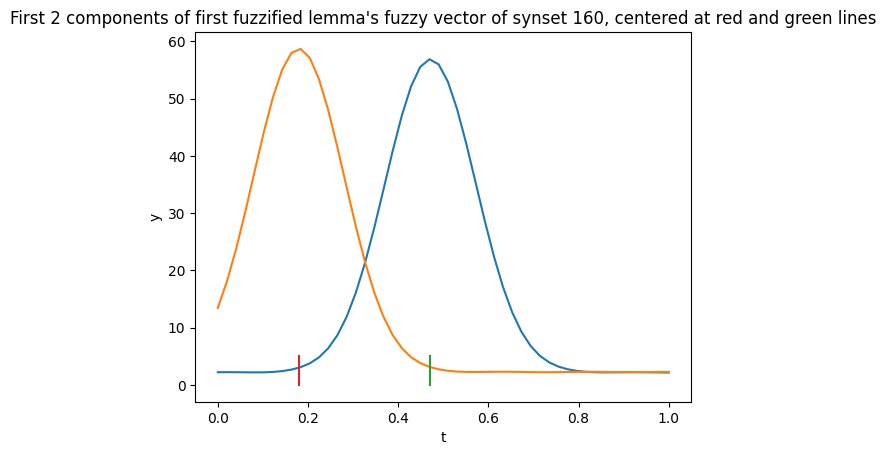

In [21]:
import matplotlib.pyplot as plt

# pick a random row in wn_df
row_idx = random.choice(wn_df.index)
# get the fourier tensors for the first lemma's fuzzy vect
fuzzy_tensors = wn_df.loc[row_idx, 'lemmas_vects_fuzzy']
fuzzy_vects = fuzzy_tensors[0]
# evaluate a linspaced series of values between 0, 1
#   using the coefficients from fuzzy_vect
test_pts_x = np.linspace(0, 1, 50)
test_pts_y0 = [fuzzifier.fuzzifier.evaluate_component_pdf(fuzzy_vects[0], x) for x in test_pts_x]
test_pts_y1 = [fuzzifier.fuzzifier.evaluate_component_pdf(fuzzy_vects[1], x) for x in test_pts_x]
mu0 = wn_df.loc[row_idx, 'lemmas_vects'][0][0]
mu1 = wn_df.loc[row_idx, 'lemmas_vects'][0][1]

print(f"First component of first lemma's vector for synset {row_idx}: {mu0}")
print()
print(f"Shape of fuzzy tensor of first 2 components of first lemma's vector for synset {row_idx}: {fuzzy_vects[0].shape}, {fuzzy_vects[1].shape}")
print()
# print(f"Fuzzy tensor of first component of first lemma's vector for synset {row_idx}:\n{fuzzy_vects[0]}")
# print(f"Fuzzy tensor of second component of first lemma's vector for synset {row_idx}:\n{fuzzy_vects[1]}")
plt.plot(test_pts_x, test_pts_y0)
plt.plot(test_pts_x, test_pts_y1)
plt.plot([mu0]*len(test_pts_x), 5*test_pts_x)
plt.plot([mu1]*len(test_pts_x), 5*test_pts_x)
plt.title(f"First 2 components of first fuzzified lemma's fuzzy vector of synset {row_idx}, centered at red and green lines")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

## Check fuzzy intersection

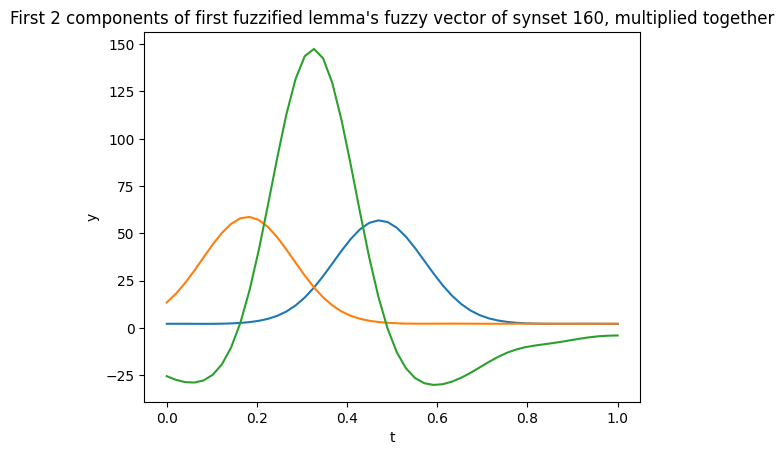

In [22]:
test_pts_x = np.linspace(0, 1, 50)
intersected_components = fuzzifier.fuzzifier.intersection(fuzzy_vects[0], fuzzy_vects[1])
test_pts_y_conv = [fuzzifier.fuzzifier.evaluate_component_pdf(intersected_components, x) for x in test_pts_x]

plt.plot(test_pts_x, test_pts_y0)
plt.plot(test_pts_x, test_pts_y1)
plt.plot(test_pts_x, test_pts_y_conv)
plt.title(f"First 2 components of first fuzzified lemma's fuzzy vector of synset {row_idx}, multiplied together")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

## Check integration

In [23]:
print(f"Area under first component of first lemma's vector for synset {row_idx}: {fuzzifier.fuzzifier._integrate(fuzzy_vects[0])}")
print(f"Area under second component of first lemma's vector for synset {row_idx}: {fuzzifier.fuzzifier._integrate(fuzzy_vects[1])}")
print(f"Area under intersection of first 2 components of first lemma's vector for synset {row_idx}: {fuzzifier.fuzzifier._integrate(intersected_components)}")

Area under first component of first lemma's vector for synset 160: 1.0000001192092896
Area under second component of first lemma's vector for synset 160: 0.9999999403953552
Area under intersection of first 2 components of first lemma's vector for synset 160: 1.0


## Check self-similarity

In [24]:
print(f"Similarity of first component of first lemma's vector for synset {row_idx} to itself: {fuzzifier.fuzzifier.similarity(fuzzy_vects[0], fuzzy_vects[0])}")
print(f"Similarity of second component of first lemma's vector for synset {row_idx} to itself: {fuzzifier.fuzzifier.similarity(fuzzy_vects[1], fuzzy_vects[1])}")

Similarity of first component of first lemma's vector for synset 160 to itself: 0.9999999403953552
Similarity of second component of first lemma's vector for synset 160 to itself: 1.0


In [25]:
intersected_components

<tf.Tensor: shape=(2, 33), dtype=float32, numpy=
array([[ 4.5112225e-01,  8.7240970e-01,  1.0786819e+00,  9.7859049e-01,
         5.6132615e-01, -1.0173635e-01, -8.7768680e-01, -1.6080441e+00,
        -2.1490393e+00, -2.4048533e+00, -2.3455665e+00, -2.0068266e+00,
        -1.4737281e+00, -8.5540497e-01, -2.5830871e-01,  2.3490904e-01,
         5.7684100e-01,  7.5644171e-01,  7.9201156e-01,  7.1980405e-01,
         5.8214688e-01,  4.1797000e-01,  2.5715640e-01,  1.1869784e-01,
         1.1682819e-02, -6.2214408e-02, -1.0593161e-01, -1.2467923e-01,
        -1.2435964e-01, -1.1069809e-01, -8.8855609e-02, -6.3278958e-02,
        -3.7621386e-02],
       [-5.6678016e-02,  2.4367099e-01,  7.7034080e-01,  1.3858935e+00,
         1.9257815e+00,  2.2423007e+00,  2.2423527e+00,  1.9087572e+00,
         1.3003241e+00,  5.3243399e-01, -2.5470418e-01, -9.3028951e-01,
        -1.4003875e+00, -1.6225567e+00, -1.6060693e+00, -1.4003124e+00,
        -1.0766066e+00, -7.0930976e-01, -3.6090103e-01, -7.356

In [26]:
print(f"Similarity of first lemma's vector for synset {row_idx} to itself: {fuzzifier.similarity(fuzzy_tensors[0], fuzzy_tensors[0])}")
print(f"Similarity of second lemma's vector for synset {row_idx} to itself: {fuzzifier.similarity(fuzzy_tensors[1], fuzzy_tensors[1])}")

Similarity of first lemma's vector for synset 160 to itself: 1.0
Similarity of second lemma's vector for synset 160 to itself: 1.0


# Evaluate Inner Product (IP) Correllations

In [27]:
sim = tf.keras.losses.CosineSimilarity(
    axis=-1,
    reduction='sum_over_batch_size',
    name='cosine_similarity'
)

In [28]:
def cosine_similarity(a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
  return -1*sim(a, b).numpy()

In [29]:
sample_size = 200
random_pairing_indices = [tuple(random.sample(range(len(wn_df)), 2)) for i in range(sample_size)]

eval_dict = {
    # for comparing synset-gloss IPs
    "syn_gloss_cosine_similarities": list(),
    "syn_gloss_fuzzy_similarities": list(),

    # for comparing lemma-lemma IPs
    "lemma_cosine_similarities": list(),
    "lemma_fuzzy_similarities": list(),

    # for comparing syn-ant IPs
    "syn_ant_cosine_similarities": list(),
    "syn_ant_fuzzy_similarities": list(),
}

## Random lemma pairs

In [30]:
for a, b in random_pairing_indices:
  lemma_a_tens = wn_df.loc[a, 'lemmas_vects'][0]
  lemma_b_tens = wn_df.loc[b, 'lemmas_vects'][0]
  eval_dict["lemma_cosine_similarities"].append(cosine_similarity(lemma_a_tens, lemma_b_tens))

  lemma_a_tens_fuzzy = wn_df.loc[a, 'lemmas_vects_fuzzy'][0]
  lemma_b_tens_fuzzy = wn_df.loc[b, 'lemmas_vects_fuzzy'][0]
  eval_dict["lemma_fuzzy_similarities"].append(fuzzifier.similarity(
        lemma_a_tens_fuzzy,
        lemma_b_tens_fuzzy
  ).numpy())

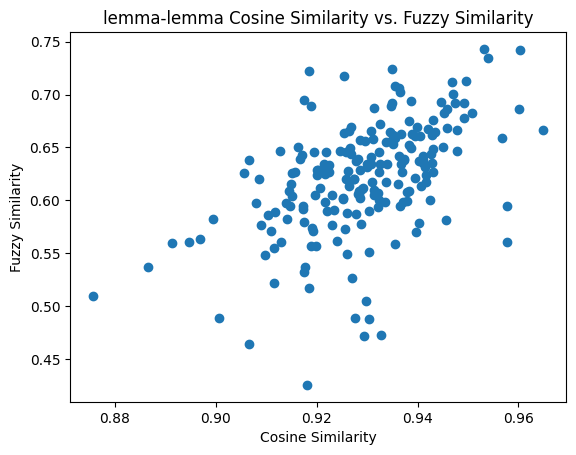

In [31]:
plt.scatter(eval_dict["lemma_cosine_similarities"], eval_dict["lemma_fuzzy_similarities"])
plt.xlabel("Cosine Similarity")
plt.ylabel("Fuzzy Similarity")
plt.title("lemma-lemma Cosine Similarity vs. Fuzzy Similarity")
plt.show()

## Synset - gloss similarities

In [32]:
for a, b in random_pairing_indices:
  synset_vect = wn_df.loc[a, 'synset_vect']
  gloss_vect = wn_df.loc[a, 'gloss_vect']
  eval_dict["syn_gloss_cosine_similarities"].append(cosine_similarity(synset_vect, gloss_vect))

  synset_vect_fuzzy = wn_df.loc[a, 'synset_vect_fuzzy']
  gloss_vect_fuzzy = wn_df.loc[a, 'gloss_vect_fuzzy']
  eval_dict["syn_gloss_fuzzy_similarities"].append(fuzzifier.similarity(
        synset_vect_fuzzy,
        gloss_vect_fuzzy
  ).numpy())

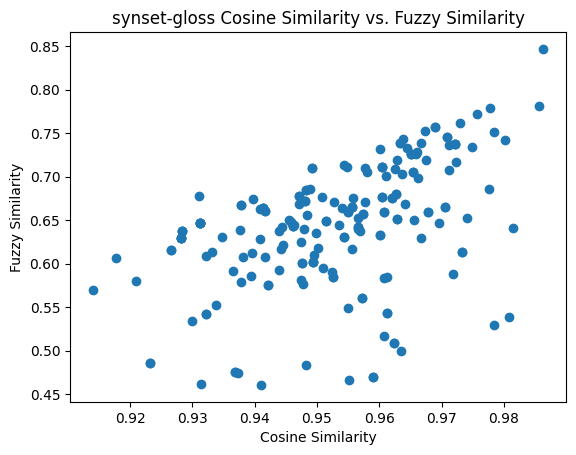

In [33]:
# plot eval_df["cosine_similarities"] against eval_df["fuzzy_similarities"]
plt.scatter(eval_dict["syn_gloss_cosine_similarities"], eval_dict["syn_gloss_fuzzy_similarities"])
plt.xlabel("Cosine Similarity")
plt.ylabel("Fuzzy Similarity")
plt.title("synset-gloss Cosine Similarity vs. Fuzzy Similarity")
plt.show()

## synset-antonym similarities

In [34]:
for a, b in random_pairing_indices:
  synset_vect = wn_df.loc[a, 'synset_vect']
  antonym_vect = wn_df.loc[a, 'antonyms_vects'][0]
  eval_dict["syn_ant_cosine_similarities"].append(cosine_similarity(synset_vect, antonym_vect))

  synset_vect_fuzzy = wn_df.loc[a, 'synset_vect_fuzzy']
  ant_vect_fuzzy = wn_df.loc[a, 'antonyms_vects_fuzzy'][0]
  eval_dict["syn_ant_fuzzy_similarities"].append(fuzzifier.similarity(
        synset_vect_fuzzy,
        gloss_vect_fuzzy
  ).numpy())

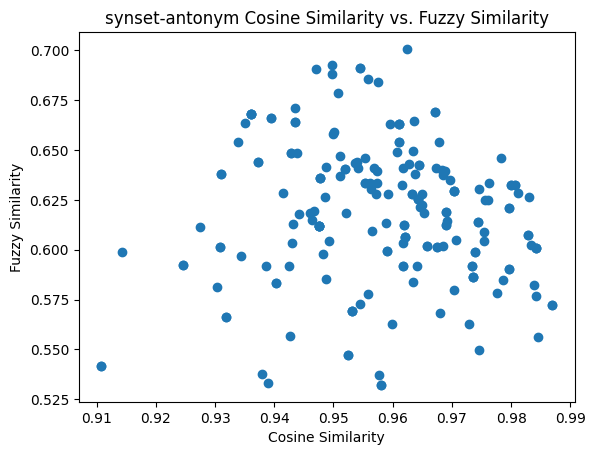

In [35]:
# plot eval_df["cosine_similarities"] against eval_df["fuzzy_similarities"]
plt.scatter(eval_dict["syn_ant_cosine_similarities"], eval_dict["syn_ant_fuzzy_similarities"])
plt.xlabel("Cosine Similarity")
plt.ylabel("Fuzzy Similarity")
plt.title("synset-antonym Cosine Similarity vs. Fuzzy Similarity")
plt.show()

## Correlation coefficients

In [36]:
eval_df = pd.DataFrame.from_dict(eval_dict)
eval_df.head()

,syn_gloss_cosine_similarities,syn_gloss_fuzzy_similarities,lemma_cosine_similarities,lemma_fuzzy_similarities,syn_ant_cosine_similarities,syn_ant_fuzzy_similarities
0,0.975710,0.771508,0.919115,0.573373,0.968812,0.639582
1,0.933821,0.551970,0.926363,0.665743,0.964111,0.591606
2,0.962088,0.675081,0.919905,0.557170,0.961091,0.654246
3,0.968880,0.756904,0.931385,0.604704,0.980642,0.632547
4,0.960486,0.711309,0.934539,0.664936,0.970400,0.629203


In [37]:
# lemma-lemma
eval_df[["lemma_cosine_similarities", "lemma_fuzzy_similarities"]].corr()

,lemma_cosine_similarities,lemma_fuzzy_similarities
lemma_cosine_similarities,1.000000,0.518076
lemma_fuzzy_similarities,0.518076,1.000000


In [38]:
# synset-gloss
eval_df[["syn_gloss_cosine_similarities", "syn_gloss_fuzzy_similarities"]].corr()

,syn_gloss_cosine_similarities,syn_gloss_fuzzy_similarities
syn_gloss_cosine_similarities,1.000000,0.469294
syn_gloss_fuzzy_similarities,0.469294,1.000000


In [39]:
# synset-antonym
eval_df[["syn_ant_cosine_similarities", "syn_ant_fuzzy_similarities"]].corr()

,syn_ant_cosine_similarities,syn_ant_fuzzy_similarities
syn_ant_cosine_similarities,1.000000,-0.056376
syn_ant_fuzzy_similarities,-0.056376,1.000000


## Stat analysis

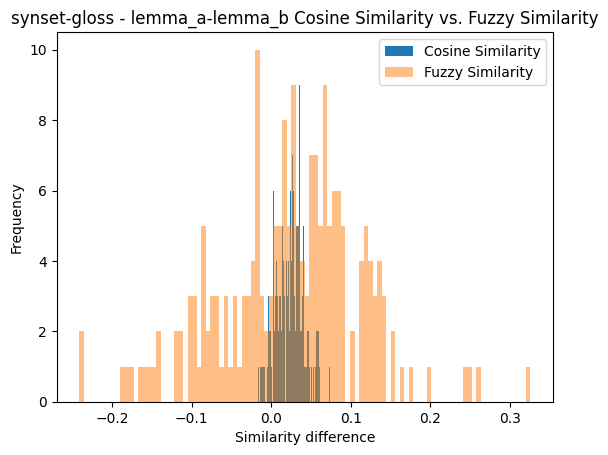

In [40]:
eval_df["separability_fuzzy"] = eval_df["syn_gloss_fuzzy_similarities"] - eval_df["lemma_fuzzy_similarities"]
eval_df["separability"] = eval_df["syn_gloss_cosine_similarities"] - eval_df["lemma_cosine_similarities"]
plt.hist(eval_df["separability"], bins=100)
plt.hist(eval_df["separability_fuzzy"], bins=100, alpha=0.5)
plt.xlabel("Similarity difference")
plt.ylabel("Frequency")
plt.legend(["Cosine Similarity", "Fuzzy Similarity"])
plt.title("synset-gloss - lemma_a-lemma_b Cosine Similarity vs. Fuzzy Similarity")
plt.show()

In [41]:
# get probability mean(eval_df["separability_fuzzy"]) > 0
stats.ttest_1samp(eval_df["separability"], 0, alternative="greater").pvalue

np.float64(7.798720671897816e-47)

In [42]:
# get probability mean(eval_df["separability_fuzzy"]) > 0
stats.ttest_1samp(eval_df["separability_fuzzy"], 0, alternative="greater").pvalue

np.float64(0.00029972891947104523)

# Test SemanticDecomposer

In [43]:
# pick a random row in wn_df
row_idx = random.choice(wn_df.index)
# get the gloss for that synset
test = wn_df.loc[row_idx, "gloss"]
amr_decomposer = SemanticKGDecomposer(test)

an overactive thyroid gland; pathologically excessive production of thyroid hormones or the condition resulting from excessive production of thyroid hormones


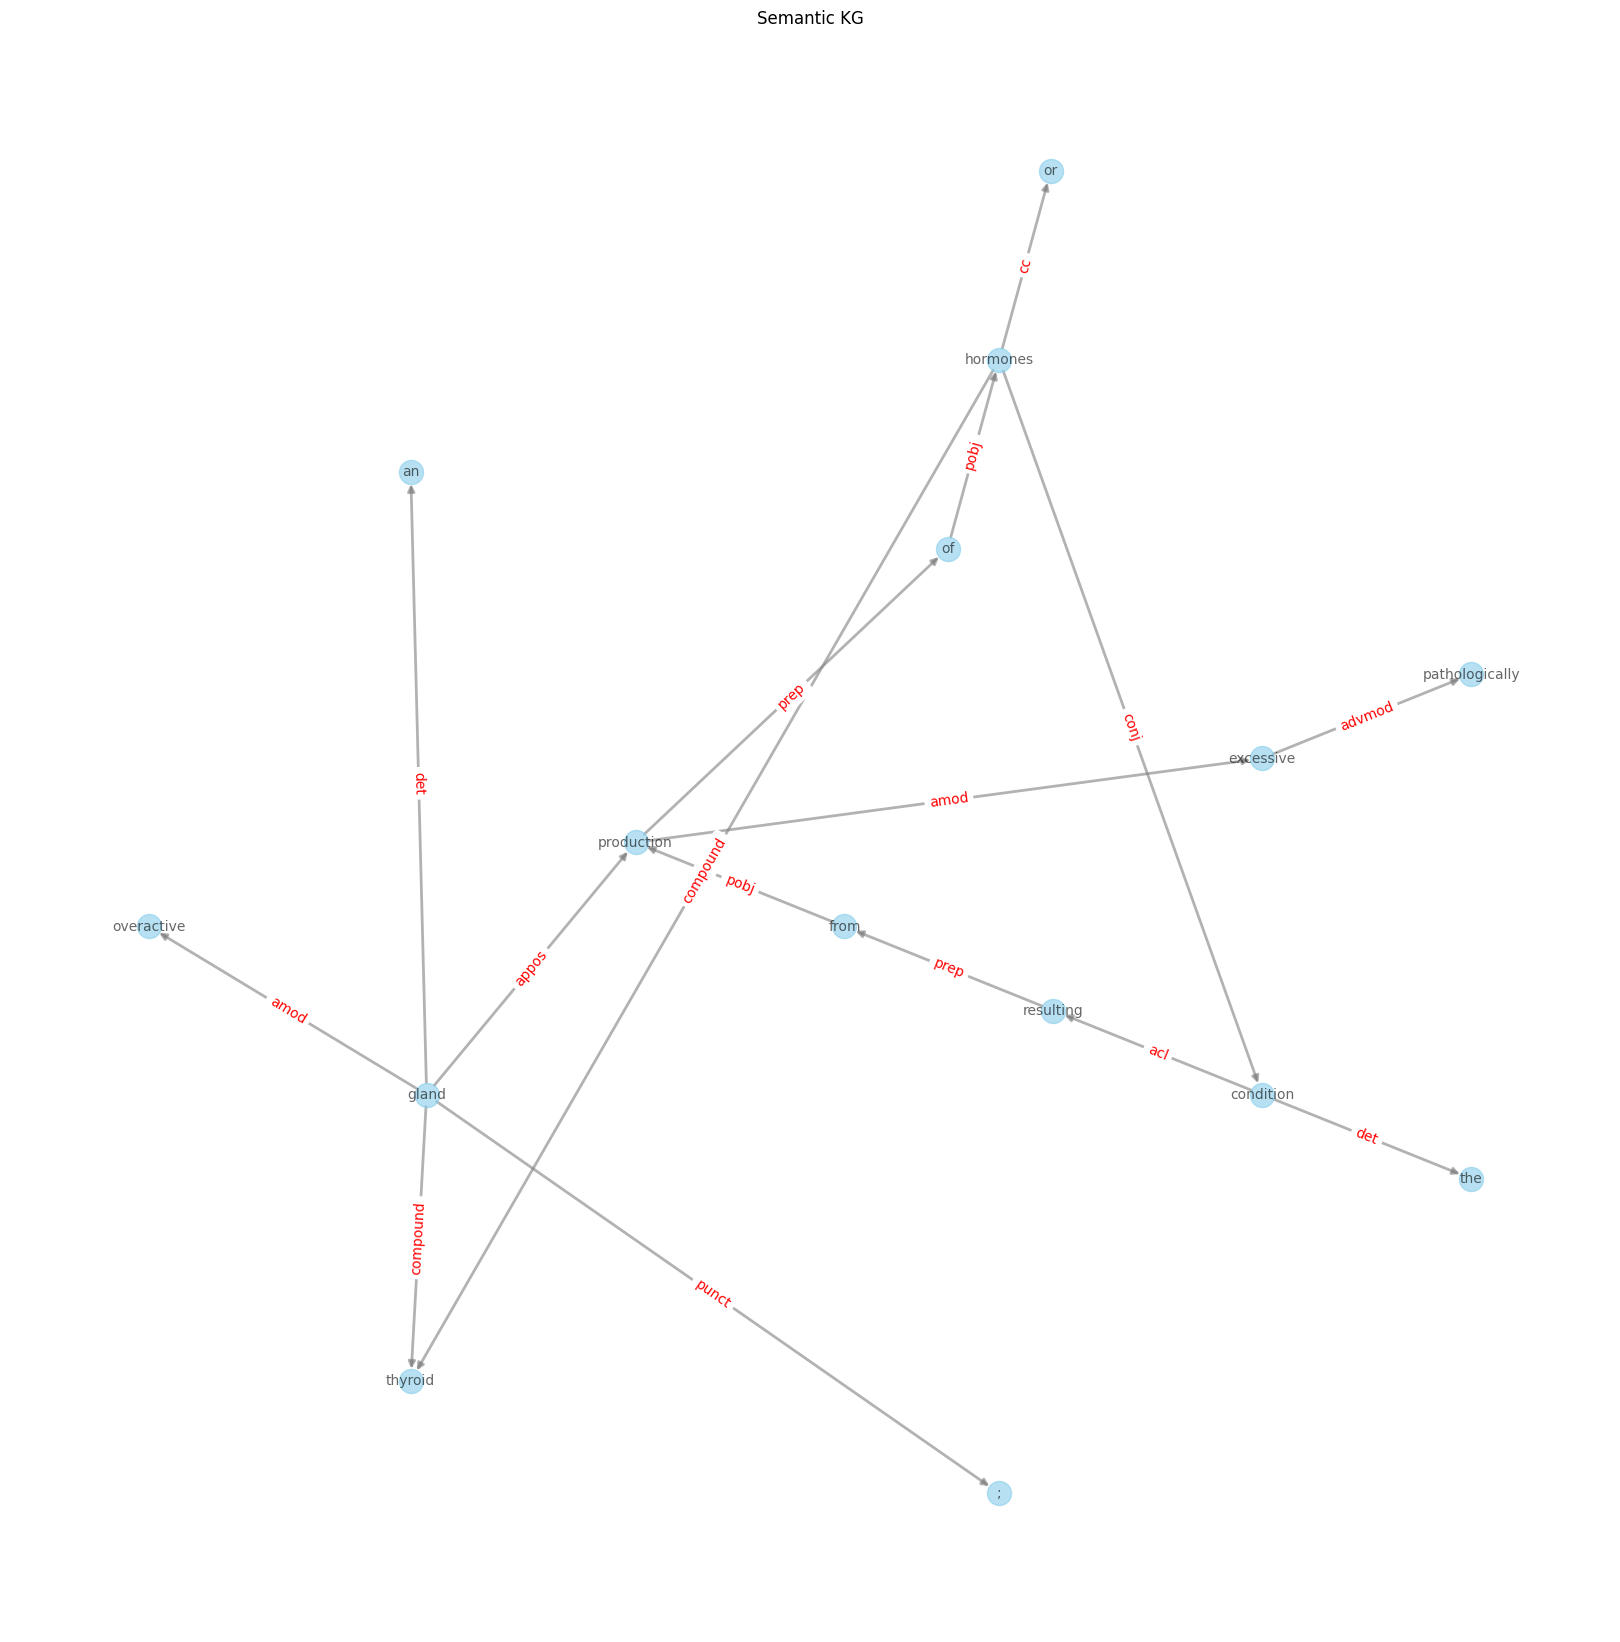

In [44]:
print(test)
amr_decomposer.draw()